In [1]:
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
import lsst.meas.base
import lsst.pex.config
import lsst.afw.display as afwDisplay
import lsst.afw.geom as afwGeom
import lsst.afw.table
import lsst.meas.algorithms
import lsst.meas.deblender
import lsst.pex.exceptions
import lsst.meas.extensions.gaap
import cProfile, pstats

## Try gaap without reference catalog

In [73]:
schema = lsst.afw.table.SourceTable.makeMinimalSchema()
detectConfig = lsst.meas.algorithms.SourceDetectionConfig()
detectConfig.returnOriginalFootprints = False
detectConfig.thresholdValue = 1
detectTask = lsst.meas.algorithms.SourceDetectionTask(config=detectConfig, schema=schema)
deblendTask = lsst.meas.deblender.SourceDeblendTask(schema=schema)

measureConfig = lsst.meas.base.SingleFrameMeasurementConfig()
measureConfig.plugins.names.add("ext_gaap_GaapFlux")
measureConfig.plugins["ext_gaap_GaapFlux"].doMeasure = True  # Set it to False for timing comparison
measureConfig.plugins["ext_gaap_GaapFlux"].doPsfPhotometry = True
measureConfig.plugins["ext_gaap_GaapFlux"].sigmas = [0.25, 0.5, 0.75, 1.0]#, 1.5, 2.0, 2.5, 3.0]
measureTask = lsst.meas.base.SingleFrameMeasurementTask(config=measureConfig, schema=schema)
# measureTask = lsst.meas.base.ForcedMeasurementTask(refSchema=schema)

In [98]:
lsst.meas.base.ForcedPhotCoaddTask??

In [93]:
exposure = lsst.afw.image.ExposureF("/projects/MERIAN/repo/S20A/9813/8,7.fits")
# exposure = lsst.afw.image.ExposureF("/projects/MERIAN/repo/HSC/runs/RC2/w_2022_04/DM-33402/20220128T212035Z/deepCoadd_calexp/9813/79/i/deepCoadd_calexp_9813_79_i_hsc_rings_v1_HSC_runs_RC2_w_2022_04_DM-33402_20220128T212035Z.fits")
# table = lsst.afw.table.SourceTable.make(schema)
# detectResult = detectTask.run(table, exposure)
# catalog = detectResult.sources

In [94]:
a = exposure.getInfo()

In [95]:
b = a.getApCorrMap()

In [96]:
list(b.keys())

['base_GaussianFlux_instFlux',
 'base_GaussianFlux_instFluxErr',
 'base_PsfFlux_instFlux',
 'base_PsfFlux_instFluxErr',
 'ext_convolved_ConvolvedFlux_0_3_3_instFlux',
 'ext_convolved_ConvolvedFlux_0_3_3_instFluxErr',
 'ext_convolved_ConvolvedFlux_0_4_5_instFlux',
 'ext_convolved_ConvolvedFlux_0_4_5_instFluxErr',
 'ext_convolved_ConvolvedFlux_0_6_0_instFlux',
 'ext_convolved_ConvolvedFlux_0_6_0_instFluxErr',
 'ext_convolved_ConvolvedFlux_0_kron_instFlux',
 'ext_convolved_ConvolvedFlux_0_kron_instFluxErr',
 'ext_convolved_ConvolvedFlux_1_3_3_instFlux',
 'ext_convolved_ConvolvedFlux_1_3_3_instFluxErr',
 'ext_convolved_ConvolvedFlux_1_4_5_instFlux',
 'ext_convolved_ConvolvedFlux_1_4_5_instFluxErr',
 'ext_convolved_ConvolvedFlux_1_6_0_instFlux',
 'ext_convolved_ConvolvedFlux_1_6_0_instFluxErr',
 'ext_convolved_ConvolvedFlux_1_kron_instFlux',
 'ext_convolved_ConvolvedFlux_1_kron_instFluxErr',
 'ext_convolved_ConvolvedFlux_2_3_3_instFlux',
 'ext_convolved_ConvolvedFlux_2_3_3_instFluxErr',
 'e

In [91]:
b['ext_gaap_GaapFlux_1_15x_Optimal_instFlux']

BoundedField(CoaddBoundedField with 34 elements, default 0 on Box2I(Point2I(27900, 31900), Extent2I(4200, 4100)))

In [76]:
print("# About to start the deblendTask at ", time.ctime())
t1 = time.time()
deblendTask.run(exposure, catalog)
t2 = time.time()
print("# Finished deblendTask in %.2f seconds." % (t2-t1))

# About to start the deblendTask at  Tue Nov  1 15:13:07 2022


Parent 7197: skipping large footprint (area: 9263012)


# Finished deblendTask in 572.42 seconds.


In [59]:
print("# Starting the measureTask at ", time.ctime())
t1 = time.time()
measureTask.run(catalog, exposure)
t2 = time.time()
print("# Finished measureTask in %.2f seconds." % (t2-t1))

# Starting the measureTask at  Tue Nov  1 14:35:52 2022
# Finished measureTask in 97.58 seconds.


In [111]:
# catalog2 = catalog.copy(deep=True)#.asAstropy()

In [65]:
good_objects = ~(catalog["ext_gaap_GaapFlux_flag"] | catalog['ext_gaap_GaapFlux_1_15x_Optimal_flag_bigPsf'])
np.sum(good_objects), len(good_objects)

(3158, 3196)

Text(0.5, 0, 'Sigmas')

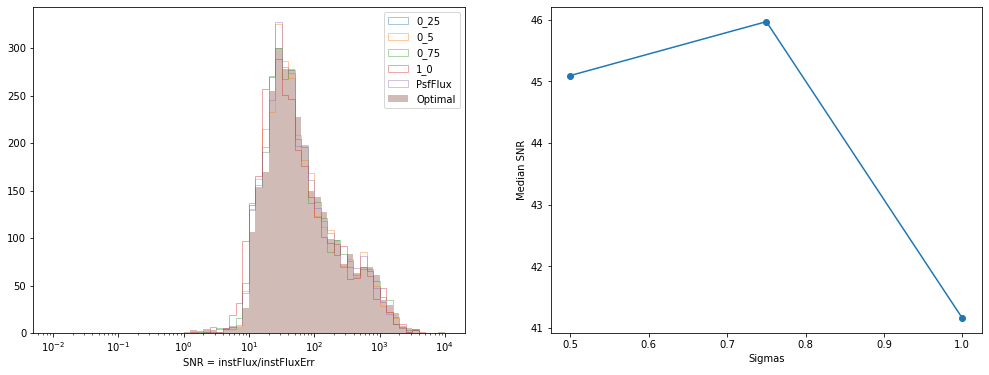

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(17,6))
bins = numpy.logspace(-2,4,61)

baseNames = list(measureConfig.plugins["ext_gaap_GaapFlux"].getAllGaapResultNames("ext_gaap_GaapFlux"))
statistic_list = []
statistic_upper_list, statistic_lower_list = [], []

for baseName in measureConfig.plugins["ext_gaap_GaapFlux"].getAllGaapResultNames("ext_gaap_GaapFlux"):
    label = baseName.split("x_")[-1]
    #if label[-1]=='5': continue
#     if "PsfFlux" in label: continue
    histtype='stepfilled' if "Optimal" in baseName else 'step'
    snr = catalog[baseName+"_instFlux"][good_objects]/catalog[baseName+"_instFluxErr"][good_objects]
    ax[0].hist(snr, bins=bins, histtype=histtype,label=label, alpha=0.4)
    statistic = numpy.nanpercentile(snr, 50)
    # statistic = numpy.nanmean(snr)
    if "Optimal" in label:
        optStatistic = numpy.nanpercentile(snr, 50)
    if not ("PsfFlux" in label or "Optimal" in label):
        statistic_list.append(statistic)
        statistic_upper_list.append(numpy.percentile(snr, 84))
        statistic_lower_list.append(numpy.percentile(snr, 16))

ax[0].set_xscale('log')
ax[0].set_xlabel("SNR = instFlux/instFluxErr")
#ax[0].set_yscale('log')
ax[0].legend(loc='best')

sigmas = measureConfig.plugins["ext_gaap_GaapFlux"].sigmas.list()
ax[1].plot(sigmas, statistic_list, 'o-')
#ax[1].fill_between(sigmas, statistic_upper_list, statistic_lower_list, alpha=0.4)
# ax[1].plot(3.6, optStatistic, "*", markersize=12)
ax[1].set_ylabel("Median SNR")
ax[1].set_xlabel("Sigmas")
# ax[1].axvline(3.5, color='k', ls='-.')

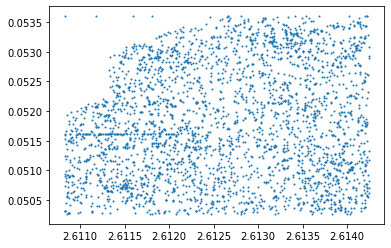

In [72]:
plt.scatter(cat2['coord_ra'], cat2['coord_dec'], s=1)

In [60]:
cat2 = catalog.copy(deep=True).asAstropy()

In [ ]:
cat2['ext_gaap_GaapFlux_OptimalShape_xx']

In [49]:
cat2 = catalog.copy(deep=True).asAstropy()

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  533.,
        2000.,  653.,    6.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

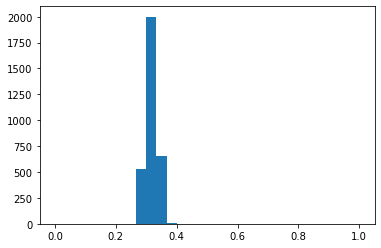

In [64]:
plt.hist(0.168 * ((cat2['base_SdssShape_psf_xx'] * cat2['base_SdssShape_psf_yy'] - cat2['base_SdssShape_psf_xy']**2))**0.25,
         range=(0, 1), bins=30)

/tmp/ipykernel_14313/1959857408.py:1: RuntimeWarning: invalid value encountered in power
  plt.hist(0.168 * ((cat2['ext_gaap_GaapFlux_OptimalShape_xx'] * cat2['ext_gaap_GaapFlux_OptimalShape_yy'] - cat2['ext_gaap_GaapFlux_OptimalShape_xy']**2))**0.25,


(array([  0.,   0.,   1.,   0.,  11.,  11., 444., 792., 763., 444., 254.,
        162.,  97.,  38.,  36.,  20.,  11.,  16.,  15.,   5.,   5.,   2.,
          3.,   2.,   4.,   2.,   0.,   3.,   4.,   3.]),
 array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
        0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
        0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
        1.        , 1.06666667, 1.13333333, 1.2       , 1.26666667,
        1.33333333, 1.4       , 1.46666667, 1.53333333, 1.6       ,
        1.66666667, 1.73333333, 1.8       , 1.86666667, 1.93333333,
        2.        ]),
 <BarContainer object of 30 artists>)

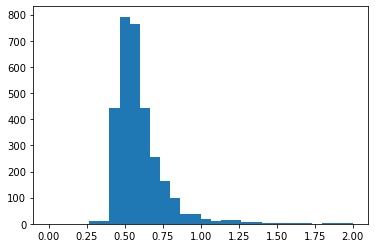

In [62]:
plt.hist(0.168 * ((cat2['ext_gaap_GaapFlux_OptimalShape_xx'] * cat2['ext_gaap_GaapFlux_OptimalShape_yy'] - cat2['ext_gaap_GaapFlux_OptimalShape_xy']**2))**0.25,
         range=(0, 2), bins=30)

## Try gaap with reference catalog

In [13]:
# Load Merian catalog
filt = 'N708'
tract = 9813
patch = 79

import lsst.daf.butler as dafButler
butler = dafButler.Butler('/projects/MERIAN/repo/')
dataId = dict(tract=tract, patch=patch, band=filt)
refCat = butler.get(
    'deepCoadd_forced_src',
    collections='DECam/runs/merian/dr1_wide',
    dataId=dataId,
    instrument='DECam',
    skymap='hsc_rings_v1',
)
refExposure = butler.get(
    'deepCoadd',
    collections='DECam/runs/merian/dr1_wide',
    dataId=dataId,
    instrument='DECam',
    skymap='hsc_rings_v1',
)

In [16]:
refExposure.wcs

FITS standard SkyWcs:
Sky Origin: (150.2479338843, +2.2314049587)
Pixel Origin: (17999, 17999)
Pixel Scale: 0.168 arcsec/pixel

In [17]:
exposure.wcs

FITS standard SkyWcs:
Sky Origin: (150.2479338843, +2.2314049587)
Pixel Origin: (17999, 17999)
Pixel Scale: 0.168 arcsec/pixel

In [8]:
schema = lsst.afw.table.SourceTable.makeMinimalSchema()
detectConfig = lsst.meas.algorithms.SourceDetectionConfig()
detectConfig.returnOriginalFootprints = False
detectConfig.thresholdValue = 10
# detectTask = lsst.meas.algorithms.SourceDetectionTask(config=detectConfig, schema=schema)
# deblendTask = lsst.meas.deblender.SourceDeblendTask(schema=schema)

measureConfig = lsst.meas.base.SingleFrameMeasurementConfig()
measureConfig.plugins.names.add("ext_gaap_GaapFlux")
measureConfig.plugins["ext_gaap_GaapFlux"].doMeasure = True  # Set it to False for timing comparison
measureConfig.plugins["ext_gaap_GaapFlux"].doPsfPhotometry = True
measureConfig.plugins["ext_gaap_GaapFlux"].sigmas = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
# measureTask = lsst.meas.base.SingleFrameMeasurementTask(config=measureConfig, schema=schema)
measureTask = lsst.meas.base.ForcedMeasurementTask(refSchema=refCat.schema)

In [18]:
exposure = lsst.afw.image.ExposureF("/projects/MERIAN/repo/S20A/9813/8,7.fits")
table = lsst.afw.table.SourceTable.make(schema)
# detectResult = detectTask.run(table, exposure)
# catalog = detectResult.sources
catalog = measureTask.generateMeasCat(refExposure, refCat, refExposure.wcs)

In [19]:
print("# Starting the measureTask at ", time.ctime())
t1 = time.time()
measureTask.run(catalog, exposure, refCat=refCat, refWcs=refExposure.wcs)
t2 = time.time()
print("# Finished measureTask in %.2f seconds." % (t2-t1))

# Starting the measureTask at  Tue Nov  1 13:53:57 2022


OutOfRangeError: 
  File "include/lsst/afw/geom/SpanSetFunctorGetters.h", line 174, in void lsst::afw::geom::details::ImageNdGetter<T, N, C>::checkExtents(const lsst::geom::Box2I&, int) const [with T = float; int N = 2; int C = 1]
    SpanSet bounding box lands outside array {0}
lsst::pex::exceptions::OutOfRangeError: 'SpanSet bounding box lands outside array'


In [36]:
X, Y = [], []
for record in catalog[good_objects]:
    snr_list = []
    optShape = afwGeom.Quadrupole(record["ext_gaap_GaapFlux_OptimalShape_xx"],
                                  record["ext_gaap_GaapFlux_OptimalShape_yy"],
                                  record["ext_gaap_GaapFlux_OptimalShape_xy"],)
    optSigma = optShape.getDeterminantRadius()
    optSigma = numpy.round(optSigma*2,0)/2
    optName = measureConfig.plugins["ext_gaap_GaapFlux"]._getGaapResultName(1.15, optSigma, "ext_gaap_GaapFlux")
    for baseName in measureConfig.plugins["ext_gaap_GaapFlux"].getAllGaapResultNames("ext_gaap_GaapFlux"):
        if not ("PsfFlux" in baseName or "Optimal" in baseName):
            try:
                snr = record[baseName+"_instFlux"]/record[baseName+"_instFluxErr"]
                snr_list.append(snr)
            except ZeroDivisionError:
                continue
        elif "Optimal" in baseName:
            optimalSnr = record[baseName+"_instFlux"]/record[baseName+"_instFluxErr"]

        if baseName==optName:
            optSnr = snr
        if 'x_3_5' in baseName:
            optSnr = snr
            
    boostFactor = optimalSnr/optSnr # numpy.nanpercentile(snr_list, 50)
    shape = record.getShape()
    ellip = (shape.getIxx()-shape.getIyy()) + 1j*2*shape.getIxy()
    ellip /= (shape.getIxx()+shape.getIyy())
    
    X.append( numpy.hypot(ellip.real, ellip.imag))
    Y.append(boostFactor)
    
Y = numpy.array(Y)

(-1.0, 10.0)

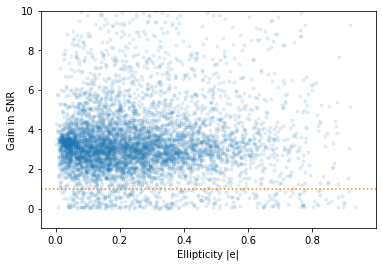

In [39]:
plt.plot(X, Y, '.', alpha=0.1)
plt.axhline(1.0, color='C1',ls=':')
#plt.yscale('log')
plt.ylabel("Gain in SNR")
plt.xlabel("Ellipticity |e|")
# ymin, ymax = 0.8, 2.7
plt.ylim([-1, 10])
# plt.title(f"Plot covers {100.*((Y>ymin)&(Y<ymax)).mean():.2f} % of the sources.")

In [40]:
def printShape(shape):
    ixx, iyy, ixy = shape.getParameterVector()
    det = shape.getDeterminantRadius()
    complex_ellip = ((ixx-iyy)+1j*2*ixy)/(ixx+iyy)
    ellip = numpy.hypot(complex_ellip.real, complex_ellip.imag)
    # return f"Quad(ixx={ixx:.2f}, iyy={iyy:.2f}, ixy={ixy:.2f}); det={det:.1f}; |e|={ellip:.2f}"
    return rf"$\sigma = ${det:.1f}; |e|={ellip:.2f}"

printShape(shape)

'$\\sigma = $2.2; |e|=0.44'

Text(0.5, 1.0, 'recordId = 210')

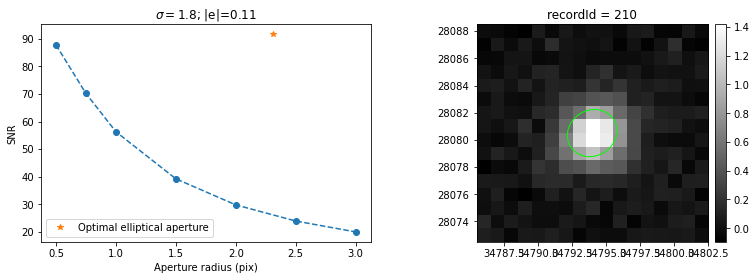

In [41]:
recordId = 210
scalingFactor = 1.15

def getSnr(sigmas):
    for sigma in sigmas:
        baseName = measureConfig.plugins["ext_gaap_GaapFlux"]._getGaapResultName(scalingFactor, sigma, "ext_gaap_GaapFlux")
        snr = catalog[recordId][baseName+"_instFlux"]/catalog[recordId][baseName+"_instFluxErr"]
        yield snr
        
sigmas = numpy.array(measureConfig.plugins["ext_gaap_GaapFlux"].sigmas)
snrs = numpy.array(list(getSnr(sigmas)))

fig, ax = plt.subplots(1, 2, figsize=(13,4))
ax[0].plot(sigmas[snrs>0], snrs[snrs>0], 'o--')

shape = catalog[recordId].getShape()
optShape = afwGeom.Quadrupole(catalog[recordId]["ext_gaap_GaapFlux_OptimalShape_xx"],
                              catalog[recordId]["ext_gaap_GaapFlux_OptimalShape_yy"],
                              catalog[recordId]["ext_gaap_GaapFlux_OptimalShape_xy"],)
sigma = optShape.getDeterminantRadius()
snr = list(getSnr(("Optimal",)))[0]
ax[0].plot(sigma, snr, '*', label='Optimal elliptical aperture')

ax[0].set_ylabel("SNR")
ax[0].set_xlabel("Aperture radius (pix)")
ax[0].set_title(printShape(shape))
#plt.yscale('log')
ax[0].legend(loc='best')


afwDisplay.setDefaultBackend('matplotlib')
plt.sca(ax[1])
display = afwDisplay.Display(frame=fig)
# display.scale("linear", "zscale")
display.setMaskTransparency(100)
footprint = catalog[recordId].getFootprint()
bbox = footprint.getBBox()
cutout = exposure[bbox]
display.mtv(cutout)
display.dot(shape, *bbox.getCenter())
ax[1].set_title(f"recordId = {recordId}")

In [16]:
import astropy.units as u
from astropy.table import Table

In [18]:
filt = 'N708'
tract = 9813
patch = 79

import lsst.daf.butler as dafButler
butler = dafButler.Butler('/projects/MERIAN/repo/')
dataId = dict(tract=tract, patch=patch, band=filt)
refCat = butler.get(
    'deepCoadd_forced_src',
    collections='DECam/runs/merian/dr1_wide',
    dataId=dataId,
    instrument='DECam',
    skymap='hsc_rings_v1',
)
img = butler.get(
    'deepCoadd',
    collections='DECam/runs/merian/dr1_wide',
    dataId=dataId,
    instrument='DECam',
    skymap='hsc_rings_v1',
)

In [19]:
refCat

<class 'lsst.afw.table.SourceCatalog'>
         id              coord_ra      ... base_ClassificationExtendedness_flag
                           rad         ...                                     
------------------- ------------------ ... ------------------------------------
3496147909164924929 2.6140370209365806 ...                                 True
3496147909164924930  2.613832353611896 ...                                 True
3496147909164924931 2.6136219791749125 ...                                 True
3496147909164924932 2.6135844673061523 ...                                 True
3496147909164924933  2.613526577066613 ...                                 True
3496147909164924934 2.6134132363085603 ...                                 True
3496147909164924935 2.6131881848261638 ...                                 True
3496147909164924936 2.6131580165950434 ...                                 True
3496147909164924937 2.6127649905191834 ...                                 True
3